In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output

In [131]:
training_set = pd.read_csv('train_ts_top20.csv', index_col='item_id')

In [132]:
training_set = training_set.sum(axis=0)

training_set

d_1       23250
d_2       22486
d_3       17119
d_4       18764
d_5       13952
          ...  
d_1937    22148
d_1938    21871
d_1939    25656
d_1940    30845
d_1941    32168
Length: 1941, dtype: int64

In [133]:
training_set = training_set.T.values.reshape(-1, 1)

In [134]:
training_set

array([[23250],
       [22486],
       [17119],
       ...,
       [25656],
       [30845],
       [32168]])

In [135]:
train = training_set[:int(0.8 * len(training_set))]
valid = training_set[int(0.8 * len(training_set)):]

In [136]:
def sliding_windows(data, seq_length, pred_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1-pred_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+pred_length+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()

train = sc.fit_transform(train)
valid = sc.transform(valid)

seq_length = 90
pred_length = 28
x_train, y_train = sliding_windows(train, seq_length, pred_length)
x_valid, y_valid = sliding_windows(valid, seq_length, pred_length)


TrainX = Variable(torch.Tensor(np.array(x_train)))
Trainy = Variable(torch.Tensor(np.array(y_train)))
ValidX = Variable(torch.Tensor(np.array(x_valid)))
Validy = Variable(torch.Tensor(np.array(y_valid)))

In [169]:
TrainX.shape

torch.Size([1433, 90, 1])

## Encoder 

In [176]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True,
          #dropout = 0.35
        )
   
    def forward(self, x):
       
        x = x.reshape((1, self.seq_len, self.n_features))
        #print(x.shape)
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim))
              
        x, (hidden, cell) = self.rnn1(x,(h_1, c_1))
        
        
        return hidden , cell 

## Decoder 

In [177]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          #dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x, input_hidden, input_cell):
       
       
        x = x.reshape((1,1,self.n_features))
        #print("decode input",x.size())
             

        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
    
        x = self.output_layer(x)
        #print(f'forward decoder: {x.shape}')
        return x, hidden_n, cell_n

## Seq2seq

In [191]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length = 28):
        super(Seq2Seq, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.n_features = n_features
        self.output_length = output_length
        self.decoder = Decoder(seq_len, embedding_dim, n_features)
        

    def forward(self, x, prev_y):
        hidden,cell = self.encoder(x)
        
        #Prepare place holder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        dec_input = prev_y
        

        
        #itearate over LSTM - according to the required output days
        for out_days in range(self.output_length) :
            
          
            prev_x,prev_hidden,prev_cell = self.decoder(dec_input,hidden,cell)
            hidden,cell = prev_hidden,prev_cell
            
            #print(prev_x)
            #prev_x = prev_x[:,:,0:1]
            #print("preve x shape is:",prev_x.size())
           
            dec_input = prev_x
            
            targets_ta.append(prev_x.reshape(self.n_features))
           
            
        
        
        targets = torch.stack(targets_ta)

        return targets

## Train model

In [192]:
n_features = TrainX.shape[2]
hidden_dim = 90 * n_features

model = Seq2Seq(seq_length, n_features, hidden_dim)

model

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(1, 90, num_layers=3, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(1, 90, num_layers=3, batch_first=True)
    (output_layer): Linear(in_features=90, out_features=1, bias=True)
  )
)

In [193]:
from tqdm import tqdm

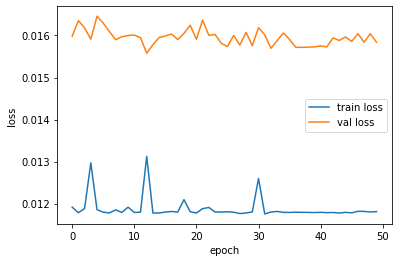

In [194]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5 ,min_lr=1e-7, eps=1e-08)

n_epochs = 50

history = dict(train=[], val=[])

for epoch in range(n_epochs):
    model = model.train()

    train_losses = []
    for i in tqdm(range(len(TrainX))):
        seq_inp = TrainX[i,:,:]
        seq_true = Trainy[i,:,:]

        optimizer.zero_grad()

        #print(f'prev_y {seq_inp[seq_length-1:seq_length,:]}')
        seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])

        
        
        loss = criterion(seq_pred, seq_true)
        
        #print(loss.item())
        

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
        for i in range(len(ValidX)):
            seq_inp = ValidX[i,:,:]
            seq_true = Validy[i,:,:]


            seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])

           
            loss = criterion(seq_pred, seq_true)
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    #if val_loss < best_loss:
    #    best_loss = val_loss
    #    torch.save(model.state_dict(), 'best_model_n_features.pt')
    #    print("saved best model epoch:",epoch,"val loss is:",val_loss)

    #print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    
    clear_output(True)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(history['train'], label='train loss')
    plt.plot(history['val'], label='val loss')

    plt.legend()
    plt.show()
    
    scheduler.step(val_loss)

In [195]:
model = model.eval()

In [196]:
preds = []

for i in range(len(ValidX)):
    seq_inp = ValidX[i,:,:]
    seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:]).detach().numpy()
    
    preds.append(seq_pred)

In [197]:
predy = np.array(preds)
predy.shape

(270, 28, 1)

In [200]:
valy = Validy.detach().numpy()
valy.shape

(270, 28, 1)

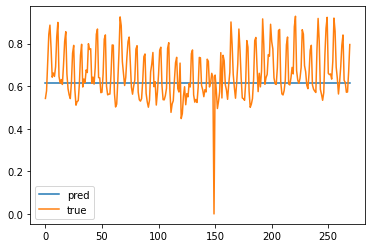

In [201]:
plt.plot(
    predy[:, 0, 0],
    label='pred'
)

plt.plot(
    valy[:, 0, 0],
    label='true'
)

plt.legend()

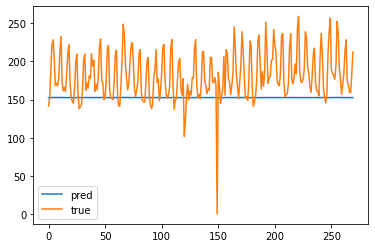

In [110]:
plt.plot(
    np.sum(predy[:, 0, :], axis=1),
    label='pred'
)

plt.plot(
    np.sum(valy[:, 0, :], axis=1),
    label='true'
)

plt.legend()